<a href="https://colab.research.google.com/github/waterstar/tensorflow/blob/master/Tennis_Forehand_%26_Backhand_Classification_Lai_Sui_Sing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tennis Forehand & Backhand Classification Project
A project to train a model to tell a given image of a tennis player on court is doing a forehand or backhand swing. The model is based on Imagenet model called InceptionV3 to do Transfer Learning. All training data are from google image search + pinterest. 

### install tensorflow

In [1]:
!pip install -qq tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 30kB/s 
     |████████████████████████████████| 4.3MB 32.2MB/s 
     |████████████████████████████████| 501kB 49.9MB/s 


## Mount my google drive to access training data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -qq /content/drive/My\ Drive/forehand.zip

In [0]:
!unzip -qq /content/drive/My\ Drive/backhand.zip

In [0]:
!ls

backhand  drive  forehand  __MACOSX  sample_data


In [0]:
!rm -r __MACOSX

#### unmount my google drive

In [0]:
drive.flush_and_unmount()

### move training data to data folder

In [0]:
!mkdir data

In [0]:
!mv forehand data
!mv backhand data

## Import Tensorflow and check if it uses GPU on virtual machine

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### check if Tensorflow and Keras has the right version

In [3]:
print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0-rc1


## Import all the libraries we need

In [0]:
%matplotlib inline
import matplotlib.pyplot as ply

import os, json
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

import tensorflow as tf


## Create dataframe from image filename, class name (back/forehand) and class (0:backhand, 1:forehand)

In [0]:
img_width, img_height = 299, 299

path = "./data/"
validation_data_dir = "./data/valid/"

import glob
import pandas as pd


data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if ('.jpg' not in name and '.jpeg' not in name):
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename class_name  class
0  /content/data/backhand/images - 2019-09-21T122...   backhand      0
1  /content/data/forehand/images - 2019-09-21T114...   forehand      1
2  /content/data/forehand/images - 2019-09-21T113...   forehand      1
3            /content/data/backhand/images (71).jpeg   backhand      0
4  /content/data/forehand/images - 2019-09-21T114...   forehand      1
1053


filename        object
class_name    category
class             int8
dtype: object

In [0]:
df.head(10)

,filename,class_name,class
0,/content/data/backhand/images - 2019-09-21T122...,backhand,0
1,/content/data/forehand/images - 2019-09-21T114...,forehand,1
2,/content/data/forehand/images - 2019-09-21T113...,forehand,1
3,/content/data/backhand/images (71).jpeg,backhand,0
4,/content/data/forehand/images - 2019-09-21T114...,forehand,1
5,/content/data/backhand/6a00adb1721cd0117f32db0...,backhand,0
6,/content/data/forehand/a2262c07cf2ebb87dc12a92...,forehand,1
7,/content/data/backhand/images - 2019-09-21T122...,backhand,0
8,/content/data/backhand/images (74).jpeg,backhand,0
9,/content/data/forehand/2Q__.jpg,forehand,1


In [0]:
df.shape

(1053, 3)

## Split dataframe to training and test data

In [0]:
# Split into train and validation sets
train_set_percentage = .9


df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [0]:
df_val.shape

(95, 3)

## Define the function to read in each jpeg file to decode and resize it

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 299,299
num_classes = 2
batch_size = 32

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  image_processed = tf.keras.applications.inception_v3.preprocess_input(image_resized) 
  label = tf.one_hot(label, num_classes)
  return image_processed, label

## from the dataframe (train & test) create the dataset and loop it through function defined above

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
train_dataset

<BatchDataset shapes: ((32, 299, 299, 3), (32, 2)), types: (tf.float32, tf.float32)>

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

## Create Base model from the Imagenet's InceptionV3

In [0]:
# create the base pre-trained model
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3),pooling=None)


87916544/87910968 [==============================] - 8s 0us/step


In [0]:
base_model.summary()

### Add a pooling layer, a fully-connected layer and a logit layer to the base model

In [0]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

# x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

### use only the 'batch_normalization' layer for training for the first attemp

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    if 'batch_normalization' in layer.name:
      print(layer.name)
      layer.trainable = True
    else:
      print(layer.name)
      layer.trainable = False


In [0]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

In [0]:
model.summary()

### use Adam optimizer and 'categorical_crossentropy' loss function

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

### define train steps and validation steps

In [0]:
train_steps = int(1053/32) #total trains set / batch_size
val_steps = int(95/32)
epochs = 1

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 32
val steps: 2


### run frist epoch

In [0]:
### Train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Train for 32 steps, validate for 2 steps
32/32 [==============================] - 48s 1s/step - loss: 0.8664 - accuracy: 0.5576 - val_loss: 0.6076 - val_accuracy: 0.7344


### run another 4 epochs

In [0]:
epochs = 4

### Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Train for 32 steps, validate for 2 steps
Epoch 1/4
32/32 [==============================] - 28s 889ms/step - loss: 0.6214 - accuracy: 0.6650 - val_loss: 0.5766 - val_accuracy: 0.7031
Epoch 2/4
32/32 [==============================] - 26s 806ms/step - loss: 0.5811 - accuracy: 0.7070 - val_loss: 0.5005 - val_accuracy: 0.7969
Epoch 3/4
32/32 [==============================] - 26s 806ms/step - loss: 0.5092 - accuracy: 0.7686 - val_loss: 0.4313 - val_accuracy: 0.7812
Epoch 4/4
32/32 [==============================] - 26s 804ms/step - loss: 0.4789 - accuracy: 0.7617 - val_loss: 0.3473 - val_accuracy: 0.8281


## Adjust the training model by using a known (based on others experiences) layer number 249

In [0]:
# blocks 172 or 249
for layer in model.layers[:249]:
    if 'batch_normalization' in layer.name:
      layer.trainable = True
      print(layer.name,':',layer.trainable)
    else:
      layer.trainable = False
      print(layer.name,':',layer.trainable)
for layer in model.layers[249:]:
    layer.trainable = True
    print(layer.name,':',layer.trainable)

### train for another 4 more epochs

In [0]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = 4,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Train for 32 steps, validate for 2 steps
Epoch 1/4
32/32 [==============================] - 29s 897ms/step - loss: 0.3930 - accuracy: 0.8291 - val_loss: 0.2735 - val_accuracy: 0.9375
Epoch 2/4
32/32 [==============================] - 26s 803ms/step - loss: 0.3239 - accuracy: 0.8701 - val_loss: 0.2699 - val_accuracy: 0.8438
Epoch 3/4
32/32 [==============================] - 26s 807ms/step - loss: 0.2700 - accuracy: 0.8965 - val_loss: 0.1786 - val_accuracy: 0.9375
Epoch 4/4
32/32 [==============================] - 26s 806ms/step - loss: 0.1993 - accuracy: 0.9268 - val_loss: 0.1187 - val_accuracy: 0.9688


#### reload the saved model in google drive

In [0]:
from tensorflow import keras
saved_model = keras.models.load_model('/content/drive/My Drive/tensorflow/fh_bh_model')

## Test the model with a image from an ATP match (show on youtube)
### the image is crop to half court to ensure that the model only predict one player. I have intentionally choosed a hard-to-tell image as the player is in the transition to the forehand 

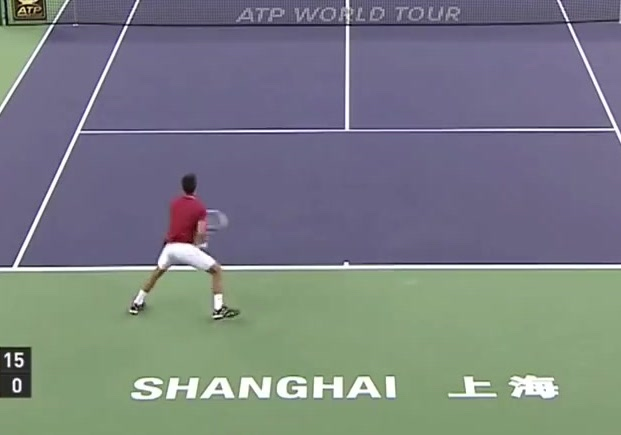

In [7]:
from IPython.display import Image

image_check = '0120 copy.jpg'

Image(image_check)

In [8]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import numpy as np

# img_path = os.path.join(image_path, image_check)
print(image_check)
img = image.load_img(image_check, target_size=(299, 299))
# img_crop = img.crop((0, 299, 0, 150))
# img_input = img_crop.resize((299,299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.inception_v3.preprocess_input(x)
print('Input image shape:', x.shape)

0120 copy.jpg
Input image shape: (1, 299, 299, 3)


Using TensorFlow backend.


## The result is rather satifying. As defined in training set, index 0 is backhand and index 1 is forehand. The prediction below show the model has 85% of confident that the player is doing forehand.

In [9]:
preds = saved_model.predict(x)
print('Predicted:', preds)

Predicted: [[0.14613062 0.8538693 ]]
